In [460]:
# !pip install autogluon==0.5.2

In [1]:
import numpy as np
import pandas as pd
import pathlib
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# AutoGluon

AutoGluon can be used to run automatically or with more precise configurations. Included models are listed here:
https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html

To fit our experiment design, it may make the most sense to run models separately. This way we'll can collect all of the forecasts produced by each model type, rather than ending up with forecasts produced by different methods all being called AutoGluon. That said, if we want to treat AutoGluon as a closed method, we can (any maybe should!) do that as well, if for no other reason to highlight the power of Auto* frameworks.

So to be clear, we can initially experiment with the underlying models' separately, e.g. with:
- NaiveModel
- ...
- TemporalFusionTransformerModel

And at the end, we can consider the use of AutoGluon's presets (e.g. `'fast_training'` and `'best_quality'`) where we would just consider those to be 'techniques' themselves to compare in a special analysis to see whether AutoGluon could have just produced the best forecast on its own.


Higher quality presets usually result in better forecasts but take longer to train. The following presets are available:

- "fast_training": fit simple statistical models (ETS, Theta, Naive, SeasonalNaive) + fast tree-based model RecursiveTabular. These models are fast to train but may not be very accurate.

- "medium_quality": all models mentioned above + deep learning model DeepAR. Default setting that produces good forecasts with reasonable training time.

- "high_quality": all models mentioned above + automatically tuned statistical models (AutoETS, AutoARIMA) + tree-based model DirectTabular + deep learning models TemporalFusionTransformer and PatchTST . Much more accurate than medium_quality, but takes longer to train.

- "best_quality": all models mentioned above + more tabular models + training multiple copies of DeepAR. Usually better than high_quality, but takes even longer to train.


In [2]:
AVAILABLE_PRESETS = [
    "fast_training",
    "medium_quality",
    "high_quality",
    "best_quality"
]

In [69]:
# # # EXP_BASE = "autogluon_global_with_scaled_covariates_experiment_preset"
# # # EXP_BASE = "autogluon_global_mean_SWE__covariates_preset"
# # # EXP_BASE = "autogluon_global_with_scaled_covariates_experiment_preset"
# # # EXP_BASE = "autogluon_preset_best_quality_global_model"
# # # EXP_BASE = "autogluon_preset_best_quality_model"


# # # EXP_BASE = "autogluon_with_scaled_covariates_Energy_EXCAUS"
# EXP_BASE = "connex_autogluon_global_with_scaled_covariates_experiment"


# # # Run all of these:
# # # EXP_BASE = "autogluon_global_with_scaled_covariates"
# # # EXP_BASE = "autogluon_global_with_scaled_covariates_climate_vars"
# # # EXP_BASE = "autogluon_with_covariates"
# # # EXP_BASE = "autogluon_global_with_scaled_covariates"
# # # EXP_BASE = "autogluon_global_with_covariates"
# # # EXP_MODEL_LIST = ["NaiveModel"]
# # # EXP_MODEL_LIST = ["NaiveModel", "SeasonalNaiveModel", "ARIMAModel", "ETSModel", "AutoETSModel"]
# # # EXP_MODEL_LIST = ["DLinearModel"]
# # # EXP_MODEL_LIST = ["DeepARModel"]
# # # EXP_MODEL_LIST = ["DirectTabularModel", "RecursiveTabularModel", "PatchTSTModel", "SimpleFeedForwardModel", "TemporalFusionTransformerModel"]
# # # EXP_MODEL_LIST = ["PatchTSTModel", "SimpleFeedForwardModel", "TemporalFusionTransformerModel"]

# # # EXP_MODEL_LIST = ["TemporalFusionTransformerModel", "best_quality"]
# EXP_MODEL_LIST = ["TemporalFusionTransformerModel", "DirectTabularModel"]
# # # EXP_MODEL_LIST = ["best_quality"]
# # # EXP_MODEL_LIST = ["medium_quality"]

# prediction_length = 12


## Load data

In [31]:
# df = pd.read_csv("../data/processed_data_inputs/Connex.csv", index_col=0)
df = pd.read_csv("../../data/processed_data_inputs/Connex.csv", index_col=0)

df.index = pd.to_datetime(df.index)
df.head()

# prediction_length = 12
context_length=52
set_freq = 'W'

df = df.resample(set_freq).sum()

In [32]:
#Define target categories 
# target_categories = ['IS_MENTAL_HEALTH', 'IS_SUBSTANCE_ABUSE']
target_categories = ['IS_MENTAL_HEALTH']

target_categories

['IS_MENTAL_HEALTH']

In [33]:
## As a place-holder using parallel CONNEX datasets as covariates 
# all_data = df.drop(columns=target_categories)
main_data = df
main_data.index.name = None


In [39]:
#Collect Government of Ontario COVID-19 datasets 
# covid_data = pd.read_csv("../data/processed_data_inputs/COVID19.csv", index_col=0)
covid_data = pd.read_csv("../../data/processed_data_inputs/COVID19.csv", index_col=0)

covid_data.index = pd.to_datetime(covid_data.index)

#Collect google trends data 
# google_data = pd.read_csv("../data/processed_data_inputs/GoogleTrends.csv", index_col=0)
google_data = pd.read_csv("../../data/processed_data_inputs/GoogleTrends.csv", index_col=0)

google_data.index = pd.to_datetime(google_data.index)


#Collect Statistics Canada data
# statcan_data = pd.read_csv("../data/processed_data_inputs/StatCan.csv", index_col=0)
statcan_data = pd.read_csv("../../data/processed_data_inputs/StatCan.csv", index_col=0)
statcan_data.index = pd.to_datetime(statcan_data.index)
statcan_data = statcan_data.resample(set_freq).interpolate(method='linear')


#Combine the FOUR sources of covariates
all_covs = main_data.join(covid_data, how='left')

all_covs = all_covs.join(google_data, how='left')

all_covs = all_covs.join(statcan_data, how='left')

# Check for duplicate indices
duplicate_indices = all_covs.index.duplicated(keep='first')
# print("Duplicate Indices:")
# print(all_covs[duplicate_indices])

# Drop duplicate indices
all_covs = all_covs[~duplicate_indices]

#Drop target dataset
all_covs = all_covs.drop(columns=target_categories)

all_covs

,IS_SUBSTANCE_ABUSE,IS_PROBLEM_GAMBLING,IS_OTHER,connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,connex_IS_OTHER_Concurrent Disorder Clients,connex_IS_MENTAL_HEALTH_Concurrent Disorders,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders,connex_IS_PROBLEM_GAMBLING_Concurrent Disorders,...,statcan_Energy,statcan_Food,statcan_Gasoline,statcan_Goods,statcan_Health and personal care,"statcan_Household operations, furnishings and equipment","statcan_Recreation, education and reading",statcan_Services,statcan_Shelter,statcan_Transportation
2015-01-04,194,36,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-11,523,78,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-18,495,80,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-25,519,68,2,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,526,81,3,3.0,5.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-07,1208,318,12,0.0,0.0,0.0,0.0,283.0,283.0,55.0,...,203.8,183.5,216.6,139.5,143.6,134.7,122.7,169.7,172.8,164.3
2023-05-14,1076,286,13,0.0,0.0,0.0,0.0,208.0,208.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-21,2207,709,21,0.0,0.0,0.0,0.0,589.0,589.0,269.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-28,1259,237,17,0.0,0.0,0.0,0.0,283.0,283.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
## pre process data 
def interpolate_nans(df):
    """
    Interpolates NaN values linearly column by column in the given DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame with potential NaN values.

    Returns:
    DataFrame: A DataFrame with NaN values linearly interpolated.
    """
    # Iterate over all columns
    for column in df.columns:
        # Check if column contains NaNs
        if df[column].isna().any():
            # Interpolate NaNs linearly
            df[column] = df[column].interpolate(method='linear')
    
    # Return the modified DataFrame
    return df

In [48]:
def organize_covariates(keyword):

    if "covariates" in EXP_BASE: 
        covariates = all_covs

    if "scaled_covariates" in EXP_BASE:
        covariate_columns = all_covs.columns[len(target_categories):]
        covariates = all_covs[covariate_columns]
        scaler = StandardScaler()
        scaler.fit(covariates)
        covariates = pd.DataFrame(scaler.transform(covariates), index=all_covs.index, columns=covariate_columns)
    

    if keyword in EXP_BASE:
        # Find columns containing 'connex'
        keyword_columns = [col for col in covariates.columns if keyword in col]
        keyword_columns    

        covariates = covariates[keyword_columns]
        
    return covariates


covariates = organize_covariates(keyword)
covariates

,connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,connex_IS_OTHER_Concurrent Disorder Clients,connex_IS_MENTAL_HEALTH_Concurrent Disorders,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders,connex_IS_PROBLEM_GAMBLING_Concurrent Disorders,connex_IS_OTHER_Concurrent Disorders,connex_IS_MENTAL_HEALTH_Families,connex_IS_SUBSTANCE_ABUSE_Families,...,connex_IS_PROBLEM_GAMBLING_Spanish,connex_IS_OTHER_Spanish,connex_IS_MENTAL_HEALTH_Italian,connex_IS_SUBSTANCE_ABUSE_Italian,connex_IS_PROBLEM_GAMBLING_Italian,connex_IS_OTHER_Italian,connex_IS_MENTAL_HEALTH_Caribbean,connex_IS_SUBSTANCE_ABUSE_Caribbean,connex_IS_PROBLEM_GAMBLING_Caribbean,connex_IS_OTHER_Caribbean
2015-01-04,-0.897704,-0.890102,-0.529005,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.856698,-0.885596,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2015-01-11,-0.897704,-0.911463,-0.529005,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.856698,-0.803923,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2015-01-18,-0.897704,-0.911463,-0.529005,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.856698,-0.885596,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2015-01-25,-0.876435,-0.890102,-0.428763,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.856698,-0.803923,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2015-02-01,-0.865801,-0.858061,-0.529005,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.856698,-0.885596,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-07,-0.897704,-0.911463,-0.529005,-0.072056,3.003773,2.998463,3.501762,0.0,0.195077,-0.068865,...,0.237621,-0.117579,-0.175872,0.048186,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2023-05-14,-0.897704,-0.911463,-0.529005,-0.072056,2.113415,2.109463,4.299230,0.0,-0.399405,-0.395557,...,-0.148184,-0.117579,0.156961,0.662733,-0.196754,-0.090462,-0.008974,-0.214815,0.777594,-0.064091
2023-05-21,-0.897704,-0.911463,-0.529005,-0.072056,6.636437,6.625584,17.723280,0.0,0.652371,0.012808,...,-0.148184,-0.117579,8.477807,-0.259087,-0.196754,-0.090462,-0.145128,-0.214815,-0.104214,-0.064091
2023-05-28,-0.897704,-0.911463,-0.529005,-0.072056,3.003773,2.998463,0.046066,0.0,1.018206,1.482923,...,-0.148184,-0.117579,-0.342289,1.584553,1.606827,-0.090462,2.986418,5.331508,0.777594,-0.064091


In [51]:
main_data = main_data[target_categories].asfreq(set_freq)
all_covs = all_covs.asfreq(set_freq)

#join main dataframe and covariates
all_data = main_data.join(covariates, how='left')

# Ensure the dataframe only contains the dates necessary 
all_data = all_data.loc[all_data.index >= '2018-01-01']
all_data = all_data.fillna(0)
all_data = all_data.asfreq(set_freq)
all_data


,IS_MENTAL_HEALTH,connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,connex_IS_OTHER_Concurrent Disorder Clients,connex_IS_MENTAL_HEALTH_Concurrent Disorders,connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders,connex_IS_PROBLEM_GAMBLING_Concurrent Disorders,connex_IS_OTHER_Concurrent Disorders,connex_IS_MENTAL_HEALTH_Families,...,connex_IS_PROBLEM_GAMBLING_Spanish,connex_IS_OTHER_Spanish,connex_IS_MENTAL_HEALTH_Italian,connex_IS_SUBSTANCE_ABUSE_Italian,connex_IS_PROBLEM_GAMBLING_Italian,connex_IS_OTHER_Italian,connex_IS_MENTAL_HEALTH_Caribbean,connex_IS_SUBSTANCE_ABUSE_Caribbean,connex_IS_PROBLEM_GAMBLING_Caribbean,connex_IS_OTHER_Caribbean
2018-01-07,1367,-0.163918,-0.174525,-0.178158,-0.072056,-0.355847,-0.356031,-0.153301,0.0,0.606642,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2018-01-14,1486,-0.004399,0.092481,-0.228279,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.307946,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2018-01-21,1637,-0.408513,-0.409491,-0.328521,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.628051,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2018-01-28,1740,0.016870,0.039080,-0.478884,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.628051,...,0.237621,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2018-02-04,1739,0.027505,0.017720,0.423295,-0.072056,-0.355847,-0.356031,-0.153301,0.0,-0.353675,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-07,2454,-0.897704,-0.911463,-0.529005,-0.072056,3.003773,2.998463,3.501762,0.0,0.195077,...,0.237621,-0.117579,-0.175872,0.048186,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2023-05-14,1569,-0.897704,-0.911463,-0.529005,-0.072056,2.113415,2.109463,4.299230,0.0,-0.399405,...,-0.148184,-0.117579,0.156961,0.662733,-0.196754,-0.090462,-0.008974,-0.214815,0.777594,-0.064091
2023-05-21,3286,-0.897704,-0.911463,-0.529005,-0.072056,6.636437,6.625584,17.723280,0.0,0.652371,...,-0.148184,-0.117579,8.477807,-0.259087,-0.196754,-0.090462,-0.145128,-0.214815,-0.104214,-0.064091
2023-05-28,2127,-0.897704,-0.911463,-0.529005,-0.072056,3.003773,2.998463,0.046066,0.0,1.018206,...,-0.148184,-0.117579,-0.342289,1.584553,1.606827,-0.090462,2.986418,5.331508,0.777594,-0.064091


In [53]:
# Check for duplicate indices
duplicate_indices = all_data.index.duplicated(keep='first')
print("Duplicate Indices:")
print(all_data[duplicate_indices])

Duplicate Indices:
Empty DataFrame
Columns: [IS_MENTAL_HEALTH, connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients, connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients, connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients, connex_IS_OTHER_Concurrent Disorder Clients, connex_IS_MENTAL_HEALTH_Concurrent Disorders, connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders, connex_IS_PROBLEM_GAMBLING_Concurrent Disorders, connex_IS_OTHER_Concurrent Disorders, connex_IS_MENTAL_HEALTH_Families, connex_IS_SUBSTANCE_ABUSE_Families, connex_IS_PROBLEM_GAMBLING_Families, connex_IS_OTHER_Families, connex_IS_MENTAL_HEALTH_Clients with Legal Issues, connex_IS_SUBSTANCE_ABUSE_Clients with Legal Issues, connex_IS_PROBLEM_GAMBLING_Clients with Legal Issues, connex_IS_OTHER_Clients with Legal Issues, connex_IS_MENTAL_HEALTH_LGBTQ+, connex_IS_SUBSTANCE_ABUSE_LGBTQ+, connex_IS_PROBLEM_GAMBLING_LGBTQ+, connex_IS_OTHER_LGBTQ+, connex_IS_MENTAL_HEALTH_Homeless Clients, connex_IS_SUBSTANCE_ABUSE_Homeless Clients, co

In [55]:
all_covariates = covariates.columns.to_list()
all_covariates

['connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients',
 'connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients',
 'connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients',
 'connex_IS_OTHER_Concurrent Disorder Clients',
 'connex_IS_MENTAL_HEALTH_Concurrent Disorders',
 'connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders',
 'connex_IS_PROBLEM_GAMBLING_Concurrent Disorders',
 'connex_IS_OTHER_Concurrent Disorders',
 'connex_IS_MENTAL_HEALTH_Families',
 'connex_IS_SUBSTANCE_ABUSE_Families',
 'connex_IS_PROBLEM_GAMBLING_Families',
 'connex_IS_OTHER_Families',
 'connex_IS_MENTAL_HEALTH_Clients with Legal Issues',
 'connex_IS_SUBSTANCE_ABUSE_Clients with Legal Issues',
 'connex_IS_PROBLEM_GAMBLING_Clients with Legal Issues',
 'connex_IS_OTHER_Clients with Legal Issues',
 'connex_IS_MENTAL_HEALTH_LGBTQ+',
 'connex_IS_SUBSTANCE_ABUSE_LGBTQ+',
 'connex_IS_PROBLEM_GAMBLING_LGBTQ+',
 'connex_IS_OTHER_LGBTQ+',
 'connex_IS_MENTAL_HEALTH_Homeless Clients',
 'connex_IS_SUBSTANCE_ABUSE_Homeless Clients',

## Define experiment cutoff dates

Our experiment design uses 6 annual cutoff dates that simulate the generation of forecast once per year over the last 6 years. We'll comsume data up to each cutoff date to fit/train models, and then evaluate over the next 18 months. In this notebook, we're only concerned with producing the retrospective forecasts and we'll do the analysis all together in another notebook.

In [57]:
# report_sim_dates = open("../data/utils/experiment_cutoff_dates.txt", 'r').read().split()
report_sim_dates = open("../../data/utils/experiment_cutoff_dates.txt", 'r').read().split()

report_sim_dates

['2020-03-01',
 '2020-09-27',
 '2021-03-14',
 '2021-09-05',
 '2021-12-12',
 '2022-04-03',
 '2022-07-31']

## AutoGluon Data Format

Instructions to format data properly for AutoGluon are here:
https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html

In [58]:
all_data_df_autogluon = all_data.reset_index().melt(id_vars='index', var_name="item_id", value_name="target").rename({"index": "timestamp"}, axis=1)
all_data_df_autogluon

,timestamp,item_id,target
0,2018-01-07,IS_MENTAL_HEALTH,1367.000000
1,2018-01-14,IS_MENTAL_HEALTH,1486.000000
2,2018-01-21,IS_MENTAL_HEALTH,1637.000000
3,2018-01-28,IS_MENTAL_HEALTH,1740.000000
4,2018-02-04,IS_MENTAL_HEALTH,1739.000000
...,...,...,...
34238,2023-05-07,connex_IS_OTHER_Caribbean,-0.064091
34239,2023-05-14,connex_IS_OTHER_Caribbean,-0.064091
34240,2023-05-21,connex_IS_OTHER_Caribbean,-0.064091
34241,2023-05-28,connex_IS_OTHER_Caribbean,-0.064091


In [59]:
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def get_autogluon_df(study_category, cutoff_date):
    global study_df
    global other_categories
    other_categories = [category for category in all_covariates if category != study_category]
    study_df = all_data_df_autogluon.loc[(all_data_df_autogluon.item_id == study_category) & (all_data_df_autogluon.timestamp <= cutoff_date)]
    for category in other_categories:
        study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
    return study_df

In [60]:
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def get_autogluon_global_df(cutoff_date):

    return all_data_df_autogluon.loc[all_data_df_autogluon.timestamp <= cutoff_date]

In [61]:
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def get_autogluon_global_with_covariates_df(cutoff_date="2023-03-01"):

    all_autogluon_dfs = []
    for category in all_data.columns:
        print(category)
        all_autogluon_dfs.append(get_autogluon_df(category, cutoff_date))
        
    return pd.concat(all_autogluon_dfs, axis=0).dropna(axis=1)

In [62]:
study_df = get_autogluon_df("IS_MENTAL_HEALTH", "2023-03-01")
study_df

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

,timestamp,item_id,target,exogenous_connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients,exogenous_connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,exogenous_connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,exogenous_connex_IS_OTHER_Concurrent Disorder Clients,exogenous_connex_IS_MENTAL_HEALTH_Concurrent Disorders,exogenous_connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders,exogenous_connex_IS_PROBLEM_GAMBLING_Concurrent Disorders,...,exogenous_connex_IS_PROBLEM_GAMBLING_Spanish,exogenous_connex_IS_OTHER_Spanish,exogenous_connex_IS_MENTAL_HEALTH_Italian,exogenous_connex_IS_SUBSTANCE_ABUSE_Italian,exogenous_connex_IS_PROBLEM_GAMBLING_Italian,exogenous_connex_IS_OTHER_Italian,exogenous_connex_IS_MENTAL_HEALTH_Caribbean,exogenous_connex_IS_SUBSTANCE_ABUSE_Caribbean,exogenous_connex_IS_PROBLEM_GAMBLING_Caribbean,exogenous_connex_IS_OTHER_Caribbean
0,2018-01-07,IS_MENTAL_HEALTH,1367.0,-0.163918,-0.174525,-0.178158,-0.072056,-0.355847,-0.356031,-0.153301,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
1,2018-01-14,IS_MENTAL_HEALTH,1486.0,-0.004399,0.092481,-0.228279,-0.072056,-0.355847,-0.356031,-0.153301,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
2,2018-01-21,IS_MENTAL_HEALTH,1637.0,-0.408513,-0.409491,-0.328521,-0.072056,-0.355847,-0.356031,-0.153301,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
3,2018-01-28,IS_MENTAL_HEALTH,1740.0,0.016870,0.039080,-0.478884,-0.072056,-0.355847,-0.356031,-0.153301,...,0.237621,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
4,2018-02-04,IS_MENTAL_HEALTH,1739.0,0.027505,0.017720,0.423295,-0.072056,-0.355847,-0.356031,-0.153301,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2023-01-29,IS_MENTAL_HEALTH,1805.0,-0.897704,-0.911463,-0.529005,-0.072056,1.662300,1.670889,0.112522,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
265,2023-02-05,IS_MENTAL_HEALTH,2869.0,-0.897704,-0.911463,-0.529005,-0.072056,2.137158,2.133169,0.311889,...,0.623425,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
266,2023-02-12,IS_MENTAL_HEALTH,2079.0,-0.897704,-0.911463,-0.529005,-0.072056,1.460485,1.457529,-0.020390,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091
267,2023-02-19,IS_MENTAL_HEALTH,2556.0,-0.897704,-0.911463,-0.529005,-0.072056,2.457687,2.453210,0.112522,...,-0.148184,-0.117579,-0.342289,-0.259087,-0.196754,-0.090462,-0.281282,-0.214815,-0.104214,-0.064091


In [63]:
autogluon_global_with_covariates_df = get_autogluon_global_with_covariates_df("2023-03-01")
autogluon_global_with_covariates_df


IS_MENTAL_HEALTH
connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients
connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Concurrent Disorder Clients
connex_IS_MENTAL_HEALTH_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders
connex_IS_PROBLEM_GAMBLING_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Concurrent Disorders
connex_IS_MENTAL_HEALTH_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Families
connex_IS_PROBLEM_GAMBLING_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Families
connex_IS_MENTAL_HEALTH_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Clients with Legal Issues
connex_IS_PROBLEM_GAMBLING_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Clients with Legal Issues
connex_IS_MENTAL_HEALTH_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_LGBTQ+
connex_IS_PROBLEM_GAMBLING_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_LGBTQ+
connex_IS_MENTAL_HEALTH_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Homeless Clients
connex_IS_PROBLEM_GAMBLING_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Homeless Clients
connex_IS_MENTAL_HEALTH_Opioid Replacement Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Opioid Replacement Clients
connex_IS_PROBLEM_GAMBLING_Opioid Replacement Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Opioid Replacement Clients
connex_IS_MENTAL_HEALTH_Gender Diverse
connex_IS_SUBSTANCE_ABUSE_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Gender Diverse
connex_IS_OTHER_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Homelessness
connex_IS_SUBSTANCE_ABUSE_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Homelessness
connex_IS_OTHER_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Caregivers
connex_IS_SUBSTANCE_ABUSE_Caregivers
connex_IS_PROBLEM_GAMBLING_Caregivers


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Caregivers
connex_IS_MENTAL_HEALTH_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Depressive Disorders
connex_IS_PROBLEM_GAMBLING_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Depressive Disorders
connex_IS_MENTAL_HEALTH_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Anxiety Disorder
connex_IS_PROBLEM_GAMBLING_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Anxiety Disorder
connex_IS_MENTAL_HEALTH_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Trauma- and Stressor-Related Disorders
connex_IS_PROBLEM_GAMBLING_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Trauma- and Stressor-Related Disorders
connex_IS_MENTAL_HEALTH_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_PROBLEM_GAMBLING_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_MENTAL_HEALTH_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Bipolar and Related Disorders (BP)
connex_IS_PROBLEM_GAMBLING_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Bipolar and Related Disorders (BP)
connex_IS_MENTAL_HEALTH_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Neurodevelopmental Disorders
connex_IS_PROBLEM_GAMBLING_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Neurodevelopmental Disorders
connex_IS_MENTAL_HEALTH_Personality Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Personality Disorders
connex_IS_PROBLEM_GAMBLING_Personality Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Personality Disorders
connex_IS_MENTAL_HEALTH_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Obsessive-Compulsive and Related Disorders
connex_IS_PROBLEM_GAMBLING_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Obsessive-Compulsive and Related Disorders
connex_IS_MENTAL_HEALTH_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Feeding and Eating Disorders
connex_IS_PROBLEM_GAMBLING_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Feeding and Eating Disorders
connex_IS_MENTAL_HEALTH_Neurocognitive Disorders (Dementia)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Neurocognitive Disorders (Dementia)
connex_IS_PROBLEM_GAMBLING_Neurocognitive Disorders (Dementia)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Neurocognitive Disorders (Dementia)
connex_IS_MENTAL_HEALTH_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indigenous Peoples
connex_IS_PROBLEM_GAMBLING_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indigenous Peoples
connex_IS_MENTAL_HEALTH_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indian
connex_IS_PROBLEM_GAMBLING_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indian
connex_IS_MENTAL_HEALTH_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_African
connex_IS_PROBLEM_GAMBLING_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_African
connex_IS_MENTAL_HEALTH_Chinese


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Chinese
connex_IS_PROBLEM_GAMBLING_Chinese


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Chinese
connex_IS_MENTAL_HEALTH_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_South Asian
connex_IS_PROBLEM_GAMBLING_South Asian
connex_IS_OTHER_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Asian
connex_IS_SUBSTANCE_ABUSE_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Asian
connex_IS_OTHER_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Arabic
connex_IS_SUBSTANCE_ABUSE_Arabic


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Arabic
connex_IS_OTHER_Arabic
connex_IS_MENTAL_HEALTH_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Spanish
connex_IS_PROBLEM_GAMBLING_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Spanish
connex_IS_MENTAL_HEALTH_Italian
connex_IS_SUBSTANCE_ABUSE_Italian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Italian
connex_IS_OTHER_Italian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Caribbean
connex_IS_SUBSTANCE_ABUSE_Caribbean
connex_IS_PROBLEM_GAMBLING_Caribbean


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Caribbean


,timestamp,item_id,target
0,2018-01-07,IS_MENTAL_HEALTH,1367.000000
1,2018-01-14,IS_MENTAL_HEALTH,1486.000000
2,2018-01-21,IS_MENTAL_HEALTH,1637.000000
3,2018-01-28,IS_MENTAL_HEALTH,1740.000000
4,2018-02-04,IS_MENTAL_HEALTH,1739.000000
...,...,...,...
34224,2023-01-29,connex_IS_OTHER_Caribbean,-0.064091
34225,2023-02-05,connex_IS_OTHER_Caribbean,-0.064091
34226,2023-02-12,connex_IS_OTHER_Caribbean,-0.064091
34227,2023-02-19,connex_IS_OTHER_Caribbean,-0.064091


In [65]:
get_autogluon_global_df("2023-04-30")

,timestamp,item_id,target
0,2018-01-07,IS_MENTAL_HEALTH,1367.000000
1,2018-01-14,IS_MENTAL_HEALTH,1486.000000
2,2018-01-21,IS_MENTAL_HEALTH,1637.000000
3,2018-01-28,IS_MENTAL_HEALTH,1740.000000
4,2018-02-04,IS_MENTAL_HEALTH,1739.000000
...,...,...,...
34233,2023-04-02,connex_IS_OTHER_Caribbean,-0.064091
34234,2023-04-09,connex_IS_OTHER_Caribbean,-0.064091
34235,2023-04-16,connex_IS_OTHER_Caribbean,-0.064091
34236,2023-04-23,connex_IS_OTHER_Caribbean,-0.064091


## Plot forecast range with context

We could add different elements to plots including some error analysis, emphasis on different quantiles, etc.

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_quantile_forecast(category, context_df, forecast_df, actual_df, cutoff_date, save_path=None, show_plots=True, model_name=""):

    fig, ax = plt.subplots(figsize=(10,6))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Ground Truth')

    # Confidence range between 0.01 and 0.99 quantiles
    ax.fill_between(
        forecast_df.index,
        forecast_df[f"q_0.05"],
        forecast_df[f"q_0.95"],
        facecolor='purple',
        alpha=0.5,
        label='95% Confidence'
    )

    # Add a line trace for the median
    ax.plot(forecast_df.index, forecast_df[f"q_0.5"], color='purple', label='Median Forecast')

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast - {cutoff_date} - COVID-19 Wave#{wave_num} \n{model_name}')  

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Interactions')
    ax.axvline(pd.to_datetime(cutoff_date), label="Cutoff Date", color='black', ls='--', ms=1, alpha=0.5)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

    # Save the figure if the path is specified
    if save_path:
        fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None) # High res for png


## Main experiment loop - non-global models

In [67]:
if "global" not in EXP_BASE:
    for model_type in EXP_MODEL_LIST:
        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
        wave_num = 0

        for cutoff_date in report_sim_dates:
            wave_num+=1
            forecast_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/forecasts"
            plot_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/plots"
            training_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/training_results"
            pathlib.Path(forecast_output_dir).mkdir(parents=True, exist_ok=True)
            pathlib.Path(plot_output_dir).mkdir(parents=True, exist_ok=True)
            pathlib.Path(training_output_dir).mkdir(parents=True, exist_ok=True)
            
            aggregated_forecast_df = pd.DataFrame()

           
            for category in target_categories:
                
                for week in range(26):
                    start_date = pd.to_datetime(cutoff_date) + pd.DateOffset(weeks=week) - pd.DateOffset(weeks=prediction_length) 
#                     end_date = start_date + pd.DateOffset(weeks=prediction_length)

                    # Assuming the function 'get_autogluon_global_df' can handle start and end dates
                    train_data = get_autogluon_global_df(start_date) 

                    predictor = TimeSeriesPredictor(
                        prediction_length=prediction_length,
                        path=f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/model_files",
                        target="target",
                        eval_metric="MAPE",
                        quantile_levels=[0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
                    )

                    if model_type in AVAILABLE_PRESETS:
                        predictor.fit(
                            train_data,
                            presets=model_type,
                            excluded_model_types=["DirectTabular"],
                            time_limit=1800*2,
                        )
                    else:
                        model_params = {}
                        predictor.fit(
                            train_data,
                            hyperparameters={
                                model_type: model_params,
                            },
                            time_limit=1800,
                        )


                        with open(f"{training_output_dir}/{category}.txt", 'w') as f:
                            f.write(str(predictor.fit_summary()))

                        forecast_df = predictor.predict(train_data).loc[category]
                        forecast_df = forecast_df.rename(
                            {"mean": "q_0.5"} | {col: f"q_{col}" for col in forecast_df.columns if col != "mean"},
                            axis=1
                        )

                        # Aggregating forecast data
                        weekly_forecast = forecast_df.iloc[-prediction_length:]  # Taking the last 'prediction_length' entries
                        aggregated_forecast_df = pd.concat([aggregated_forecast_df, pd.DataFrame(weekly_forecast.iloc[-1])], axis=1)

                aggregated_forecast_df = aggregated_forecast_df.T
                context_df = df[category].loc[(df.index >= pd.to_datetime(cutoff_date) - pd.DateOffset(weeks=context_length)) & (df.index <= cutoff_date)]
                actual_df = df[category].loc[(df.index > cutoff_date) & (df.index <= df.index.max())]

                aggregated_forecast_df.to_csv(f"{forecast_output_dir}/{category}.csv")
                plot_quantile_forecast(
                    category=category,          # The target category name
                    context_df=context_df,      # Historical data to plot
                    forecast_df=aggregated_forecast_df,    # Quantile forecast dataframe
                    actual_df=actual_df,        # 'actual' data to plot against forecast
                    save_path=f"{plot_output_dir}/{category}.svg", 
                    cutoff_date=cutoff_date,
                    show_plots=True,
                    model_name=predictor.get_model_best()
                )

# Main experiment loop - global models

IS_MENTAL_HEALTH
connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients
connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Concurrent Disorder Clients
connex_IS_MENTAL_HEALTH_Concurrent Disorders
connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Concurrent Disorders
connex_IS_OTHER_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Families
connex_IS_SUBSTANCE_ABUSE_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Families
connex_IS_OTHER_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Clients with Legal Issues
connex_IS_SUBSTANCE_ABUSE_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Clients with Legal Issues
connex_IS_OTHER_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_LGBTQ+
connex_IS_SUBSTANCE_ABUSE_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_LGBTQ+
connex_IS_OTHER_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Homeless Clients
connex_IS_SUBSTANCE_ABUSE_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Homeless Clients
connex_IS_OTHER_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Opioid Replacement Clients
connex_IS_SUBSTANCE_ABUSE_Opioid Replacement Clients
connex_IS_PROBLEM_GAMBLING_Opioid Replacement Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Opioid Replacement Clients
connex_IS_MENTAL_HEALTH_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Gender Diverse
connex_IS_PROBLEM_GAMBLING_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Gender Diverse
connex_IS_MENTAL_HEALTH_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Homelessness
connex_IS_PROBLEM_GAMBLING_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Homelessness
connex_IS_MENTAL_HEALTH_Caregivers


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Caregivers
connex_IS_PROBLEM_GAMBLING_Caregivers


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Caregivers
connex_IS_MENTAL_HEALTH_Depressive Disorders
connex_IS_SUBSTANCE_ABUSE_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Depressive Disorders
connex_IS_OTHER_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Anxiety Disorder
connex_IS_SUBSTANCE_ABUSE_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Anxiety Disorder
connex_IS_OTHER_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Trauma- and Stressor-Related Disorders
connex_IS_SUBSTANCE_ABUSE_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Trauma- and Stressor-Related Disorders
connex_IS_OTHER_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_SUBSTANCE_ABUSE_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_OTHER_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Bipolar and Related Disorders (BP)
connex_IS_SUBSTANCE_ABUSE_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Bipolar and Related Disorders (BP)
connex_IS_OTHER_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Neurodevelopmental Disorders
connex_IS_SUBSTANCE_ABUSE_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Neurodevelopmental Disorders
connex_IS_OTHER_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Personality Disorders
connex_IS_SUBSTANCE_ABUSE_Personality Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Personality Disorders
connex_IS_OTHER_Personality Disorders
connex_IS_MENTAL_HEALTH_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Obsessive-Compulsive and Related Disorders
connex_IS_PROBLEM_GAMBLING_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Obsessive-Compulsive and Related Disorders
connex_IS_MENTAL_HEALTH_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Feeding and Eating Disorders
connex_IS_PROBLEM_GAMBLING_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Feeding and Eating Disorders
connex_IS_MENTAL_HEALTH_Neurocognitive Disorders (Dementia)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Neurocognitive Disorders (Dementia)
connex_IS_PROBLEM_GAMBLING_Neurocognitive Disorders (Dementia)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Neurocognitive Disorders (Dementia)
connex_IS_MENTAL_HEALTH_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indigenous Peoples
connex_IS_PROBLEM_GAMBLING_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indigenous Peoples
connex_IS_MENTAL_HEALTH_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indian
connex_IS_PROBLEM_GAMBLING_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indian
connex_IS_MENTAL_HEALTH_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_African
connex_IS_PROBLEM_GAMBLING_African
connex_IS_OTHER_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Chinese
connex_IS_SUBSTANCE_ABUSE_Chinese


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Chinese
connex_IS_OTHER_Chinese


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_South Asian
connex_IS_SUBSTANCE_ABUSE_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_South Asian
connex_IS_OTHER_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Asian
connex_IS_SUBSTANCE_ABUSE_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Asian
connex_IS_OTHER_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Arabic
connex_IS_SUBSTANCE_ABUSE_Arabic


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Arabic
connex_IS_OTHER_Arabic


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Spanish
connex_IS_SUBSTANCE_ABUSE_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Spanish
connex_IS_OTHER_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Italian
connex_IS_SUBSTANCE_ABUSE_Italian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Italian
connex_IS_OTHER_Italian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Caribbean
connex_IS_SUBSTANCE_ABUSE_Caribbean


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Caribbean
connex_IS_OTHER_Caribbean


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}
Provided training data set with 13673 rows, 121 items (item = single time series). Average time series length is 113.0. Data frequency is 'W-SUN'.
AutoGluon will save models to ./output/experiments/connex_autogluon_global_with_scaled_covariates_experiment_TemporalFusionTransformerModel/12_weeks/2020-03-01/model_files/
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains followin

****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.930519        0.21538         309.719968   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


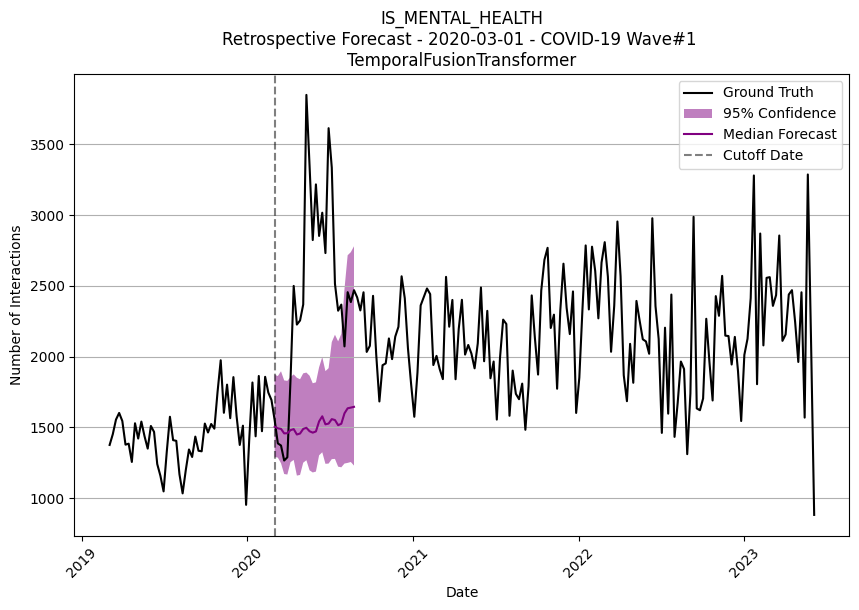

IS_MENTAL_HEALTH
connex_IS_MENTAL_HEALTH_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients
connex_IS_PROBLEM_GAMBLING_Concurrent Disorder Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Concurrent Disorder Clients
connex_IS_MENTAL_HEALTH_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Concurrent Disorders
connex_IS_PROBLEM_GAMBLING_Concurrent Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Concurrent Disorders
connex_IS_MENTAL_HEALTH_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Families
connex_IS_PROBLEM_GAMBLING_Families


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Families
connex_IS_MENTAL_HEALTH_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Clients with Legal Issues
connex_IS_PROBLEM_GAMBLING_Clients with Legal Issues


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Clients with Legal Issues
connex_IS_MENTAL_HEALTH_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_LGBTQ+
connex_IS_PROBLEM_GAMBLING_LGBTQ+


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_LGBTQ+
connex_IS_MENTAL_HEALTH_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Homeless Clients
connex_IS_PROBLEM_GAMBLING_Homeless Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Homeless Clients
connex_IS_MENTAL_HEALTH_Opioid Replacement Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Opioid Replacement Clients
connex_IS_PROBLEM_GAMBLING_Opioid Replacement Clients


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Opioid Replacement Clients
connex_IS_MENTAL_HEALTH_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Gender Diverse
connex_IS_PROBLEM_GAMBLING_Gender Diverse


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Gender Diverse
connex_IS_MENTAL_HEALTH_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Homelessness
connex_IS_PROBLEM_GAMBLING_Homelessness


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Homelessness
connex_IS_MENTAL_HEALTH_Caregivers


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Caregivers
connex_IS_PROBLEM_GAMBLING_Caregivers


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Caregivers
connex_IS_MENTAL_HEALTH_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Depressive Disorders
connex_IS_PROBLEM_GAMBLING_Depressive Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Depressive Disorders
connex_IS_MENTAL_HEALTH_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Anxiety Disorder
connex_IS_PROBLEM_GAMBLING_Anxiety Disorder


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Anxiety Disorder
connex_IS_MENTAL_HEALTH_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Trauma- and Stressor-Related Disorders
connex_IS_PROBLEM_GAMBLING_Trauma- and Stressor-Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Trauma- and Stressor-Related Disorders
connex_IS_MENTAL_HEALTH_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_PROBLEM_GAMBLING_Schizophrenia Spectrum and Other Psychotic Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Schizophrenia Spectrum and Other Psychotic Disorders
connex_IS_MENTAL_HEALTH_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Bipolar and Related Disorders (BP)
connex_IS_PROBLEM_GAMBLING_Bipolar and Related Disorders (BP)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Bipolar and Related Disorders (BP)
connex_IS_MENTAL_HEALTH_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Neurodevelopmental Disorders
connex_IS_PROBLEM_GAMBLING_Neurodevelopmental Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Neurodevelopmental Disorders
connex_IS_MENTAL_HEALTH_Personality Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Personality Disorders
connex_IS_PROBLEM_GAMBLING_Personality Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Personality Disorders
connex_IS_MENTAL_HEALTH_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Obsessive-Compulsive and Related Disorders
connex_IS_PROBLEM_GAMBLING_Obsessive-Compulsive and Related Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Obsessive-Compulsive and Related Disorders
connex_IS_MENTAL_HEALTH_Feeding and Eating Disorders
connex_IS_SUBSTANCE_ABUSE_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Feeding and Eating Disorders
connex_IS_OTHER_Feeding and Eating Disorders


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Neurocognitive Disorders (Dementia)
connex_IS_SUBSTANCE_ABUSE_Neurocognitive Disorders (Dementia)


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Neurocognitive Disorders (Dementia)
connex_IS_OTHER_Neurocognitive Disorders (Dementia)
connex_IS_MENTAL_HEALTH_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indigenous Peoples
connex_IS_PROBLEM_GAMBLING_Indigenous Peoples


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indigenous Peoples
connex_IS_MENTAL_HEALTH_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Indian
connex_IS_PROBLEM_GAMBLING_Indian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Indian
connex_IS_MENTAL_HEALTH_African
connex_IS_SUBSTANCE_ABUSE_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_African
connex_IS_OTHER_African


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Chinese
connex_IS_SUBSTANCE_ABUSE_Chinese


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Chinese
connex_IS_OTHER_Chinese
connex_IS_MENTAL_HEALTH_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_South Asian
connex_IS_PROBLEM_GAMBLING_South Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_South Asian
connex_IS_MENTAL_HEALTH_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Asian
connex_IS_PROBLEM_GAMBLING_Asian
connex_IS_OTHER_Asian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Arabic
connex_IS_SUBSTANCE_ABUSE_Arabic


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Arabic
connex_IS_OTHER_Arabic


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Spanish
connex_IS_SUBSTANCE_ABUSE_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_PROBLEM_GAMBLING_Spanish
connex_IS_OTHER_Spanish


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_MENTAL_HEALTH_Italian
connex_IS_SUBSTANCE_ABUSE_Italian
connex_IS_PROBLEM_GAMBLING_Italian


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Italian
connex_IS_MENTAL_HEALTH_Caribbean


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_SUBSTANCE_ABUSE_Caribbean
connex_IS_PROBLEM_GAMBLING_Caribbean


/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  study_df.loc[study_df.index, f"exogenous_{category}"] = all_data[category][study_df.timestamp].values
/tmp/ipykernel_1980/1138884122.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

connex_IS_OTHER_Caribbean


================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}
Provided training data set with 17303 rows, 121 items (item = single time series). Average time series length is 143.0. Data frequency is 'W-SUN'.
AutoGluon will save models to ./output/experiments/connex_autogluon_global_with_scaled_covariates_experiment_TemporalFusionTransformerModel/12_weeks/2020-09-27/model_files/
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains followin

In [ ]:
if "global" in EXP_BASE:
    for model_type in EXP_MODEL_LIST:
        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
        wave_num = 0

        for cutoff_date in report_sim_dates:
            wave_num += 1
            forecast_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/forecasts"
            plot_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/plots"
            training_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/training_results"
            pathlib.Path(forecast_output_dir).mkdir(parents=True, exist_ok=True)
            pathlib.Path(plot_output_dir).mkdir(parents=True, exist_ok=True)
            pathlib.Path(training_output_dir).mkdir(parents=True, exist_ok=True)

            if "covariates" in EXP_BASE:
                train_data = get_autogluon_global_with_covariates_df(cutoff_date)
            else:
                train_data = get_autogluon_global_df(cutoff_date)

            aggregated_forecast_df = pd.DataFrame()

           
            for category in target_categories:

                predictor = TimeSeriesPredictor(
                    prediction_length=prediction_length,
                    path=f"./output/experiments/{EXPERIMENT_NAME}/{str(prediction_length)}_weeks/{cutoff_date}/model_files",
                    target="target",
                    eval_metric="MAPE",
                    quantile_levels=[0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
                )

                if model_type in AVAILABLE_PRESETS:
                    predictor.fit(
                        train_data,
                        presets=model_type,
                        excluded_model_types=["DirectTabular"],
                        time_limit=1800*9,
                    )
                else:
                    model_params = {}
                    predictor.fit(
                        train_data,
                        hyperparameters={
                            model_type: model_params,
                        },
                        time_limit=1800,
                    )


                for week in range(26):
                    start_date = pd.to_datetime(cutoff_date) + pd.DateOffset(weeks=week) - pd.DateOffset(weeks=prediction_length) 
                    end_date = start_date + pd.DateOffset(weeks=prediction_length)

                    # Assuming the function 'get_autogluon_global_df' can handle start and end dates
                    train_data = get_autogluon_global_df(start_date) 


                    with open(f"{training_output_dir}/{category}.txt", 'w') as f:
                        f.write(str(predictor.fit_summary()))

                    forecast_df = predictor.predict(train_data).loc[category]
                    forecast_df = forecast_df.rename(
                        {"mean": "q_0.5"} | {col: f"q_{col}" for col in forecast_df.columns if col != "mean"},
                        axis=1
                    )

                    # Aggregating forecast data
                    weekly_forecast = forecast_df.iloc[-prediction_length:]  # Taking the last 'prediction_length' entries
                    aggregated_forecast_df = pd.concat([aggregated_forecast_df, pd.DataFrame(weekly_forecast.iloc[-1])], axis=1)

                aggregated_forecast_df = aggregated_forecast_df.T
                context_df = df[category].loc[(df.index >= pd.to_datetime(cutoff_date) - pd.DateOffset(weeks=context_length)) & (df.index <= cutoff_date)]
                actual_df = df[category].loc[(df.index > cutoff_date) & (df.index <= df.index.max())]

                aggregated_forecast_df.to_csv(f"{forecast_output_dir}/{category}.csv")
                plot_quantile_forecast(
                    category=category,          # The target category name
                    context_df=context_df,      # Historical data to plot
                    forecast_df=aggregated_forecast_df,    # Quantile forecast dataframe
                    actual_df=actual_df,        # 'actual' data to plot against forecast
                    save_path=f"{plot_output_dir}/{category}.svg", 
                    cutoff_date=cutoff_date,
                    show_plots=True,
                    model_name=predictor.get_model_best()
                )
            # Save the aggregated forecast outside the weekly loop
#             aggregated_forecast_df.to_csv(f"{forecast_output_dir}/aggregated_forecast.csv")

            # Other code for plotting and further analysis...


In [ ]:
predictor.get_model_best()

In [ ]:
predictor.fit_summary()